In [1]:
import shap
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import copy
from IPython.display import clear_output

from util.util_cnn import CNNModel, data_loaders, first_mnist_batch, test, \
                params_to_filename, params_from_filename, load_mnist_v4_models

from util.naming import *
from util.util_lrp import layerwise_forward_pass, compute_relevancies, LRP_global_mat, calc_mats_batch_functional, forward_and_explain
from util.util_tutorial import heatmap
from util.util_pickle import load_data, save_data, get_shap_configs, load_shaps

# pan kessel
from explanations_can_be_manipulated.src.nn.enums import ExplainingMethod, LRPRule
from explanations_can_be_manipulated.src.nn.networks import ExplainableNet
from explanations_can_be_manipulated.src.nn.utils import get_expl, plot_overview, clamp, load_image, make_dir

device = 'cpu'
method = ExplainingMethod.lrp

%matplotlib inline
%load_ext autoreload
%autoreload 2

no display found. Using non-interactive Agg backend


In [2]:
# load data and pretrained models
data, target = first_mnist_batch(batch_size=100)
background, background_target = first_mnist_batch(batch_size=100, test=False)

background = background.reshape((-1, 1, 28, 28))
test_images = data[:3].reshape((-1, 1, 28, 28))

model_dict = load_mnist_v4_models()
model_d3 = model_dict[d3_tag]

In [116]:
N = 10
M = 840

r=[]
for n in range(N):
    for m in range(M):
        if m % N == n:
            r.append(m)

In [117]:
l = len(np.unique(r))
l, np.mean(np.unique(r) == np.arange(l)), # np.unique(r, return_counts=1)

(840, 1.0)

In [67]:
import sys

print(sys.executable)

/home/johannes/msc/bin/python


In [136]:
assert 1
for fn in tqdm(sorted(os.listdir(PICKLE_PATH + 'd3'))):
    if ('shap__background' in fn) and ('0840.pickle' not in fn):
        os.remove(PICKLE_PATH + 'd3/' +fn)
        print(1, end='')

  0%|          | 0/157 [00:00<?, ?it/s]

111111111111111111111111111111111111111111111111111111111111111111111111111

In [135]:
for fn in tqdm(sorted(os.listdir(PICKLE_PATH + 'd3'))):
    if 'shap__background' in fn:
        pass #print(fn)

  0%|          | 0/19 [00:00<?, ?it/s]

## Load precomputed shapley values

In [149]:
len(os.listdir(PICKLE_PATH + 'd3')), 1696

(1629, 1696)

In [152]:
shap_configs = get_shap_configs('d3')
shap_configs

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1646/1646 [00:00<00:00, 656069.98it/s]


array(['shap__background_size-100__batch_size-10__model-cb1-8-8-8_cb2-16-16-16_seed-0',
       'shap__background_size-400__batch_size-10__model-cb1-8-8-8_cb2-16-16-16_seed-0'],
      dtype='<U77')

In [153]:
shaps_per_config = { config: load_shaps('d3', config) for config in shap_configs }
    
for config, data in (shaps_per_config.items()):
    print(config, data.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1646/1646 [00:03<00:00, 449.17it/s]


shap__background_size-100__batch_size-10__model-cb1-8-8-8_cb2-16-16-16_seed-0 (8400, 10, 1, 28, 28)
shap__background_size-400__batch_size-10__model-cb1-8-8-8_cb2-16-16-16_seed-0 (7900, 10, 1, 28, 28)


In [150]:
shaps = load_shaps('d3', shap_configs[0])
shaps.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1646/1646 [00:03<00:00, 424.82it/s]


(8400, 10, 1, 28, 28)

In [254]:
batch_size = 100
test_loader_shap = data_loaders(shapley_values_for=('d3', shap_configs[0]), shuffle=False, batch_size=batch_size)

In [138]:
shaps1 = load_data('d3', 'shap__background_size-100__batch_size-10__model-cb1-8-8-8_cb2-16-16-16_seed-0__batch-0001-0840')

In [139]:
shaps1.shape

(10, 10, 1, 28, 28)

tensor(8)


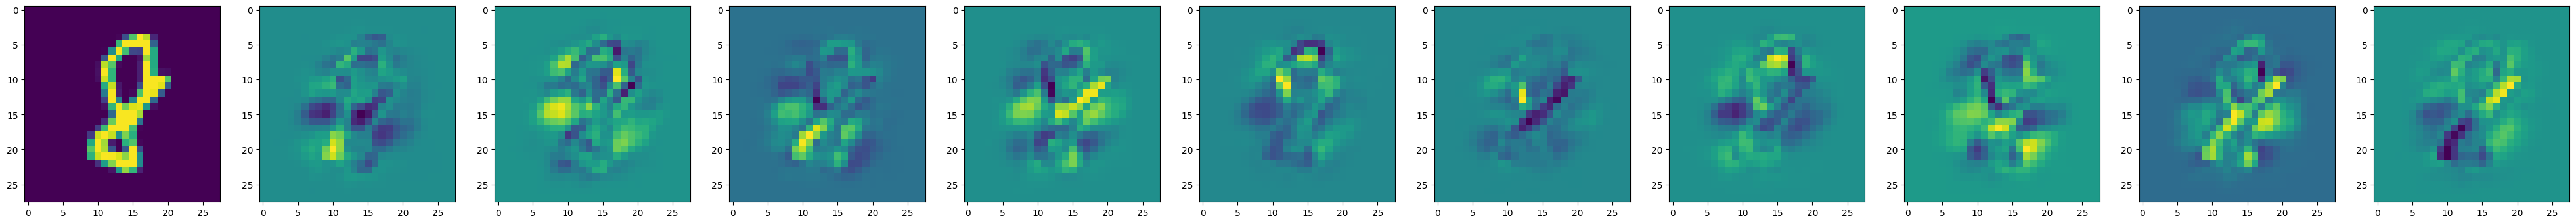

tensor(1)


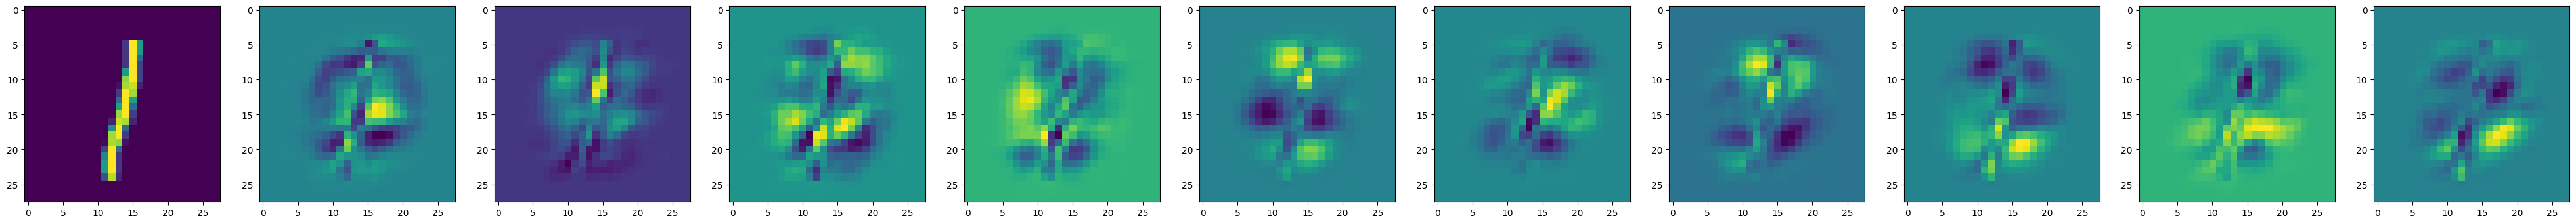

tensor(9)


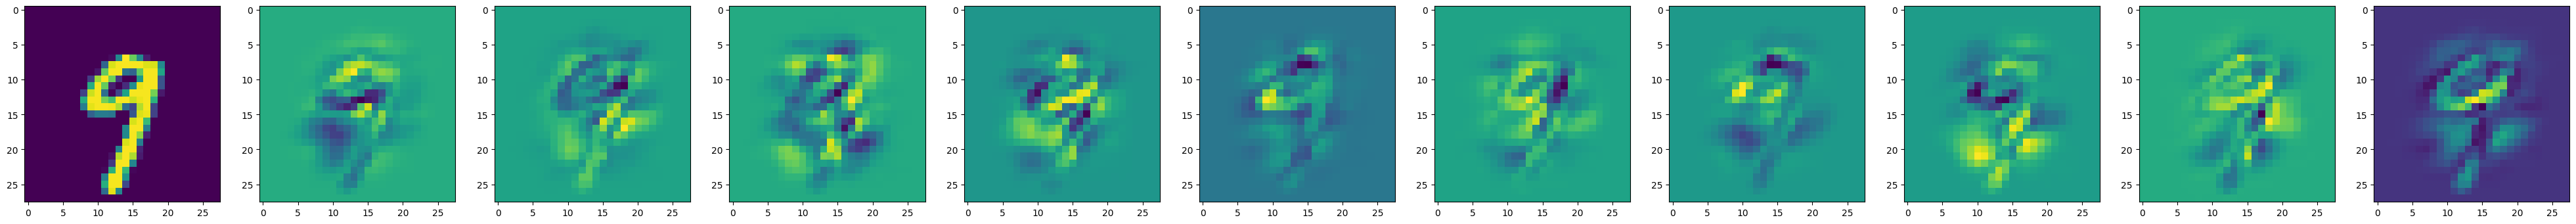

tensor(9)


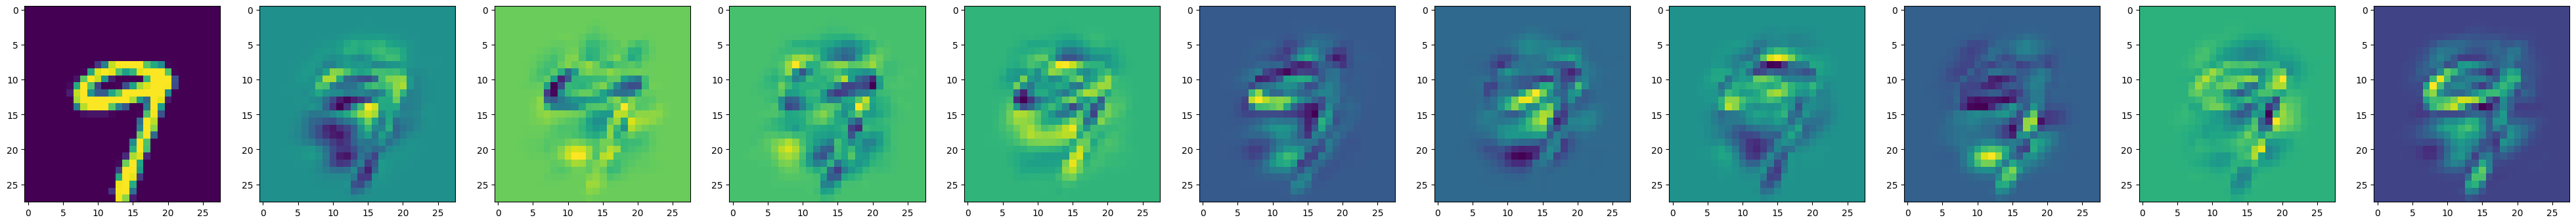

tensor(8)


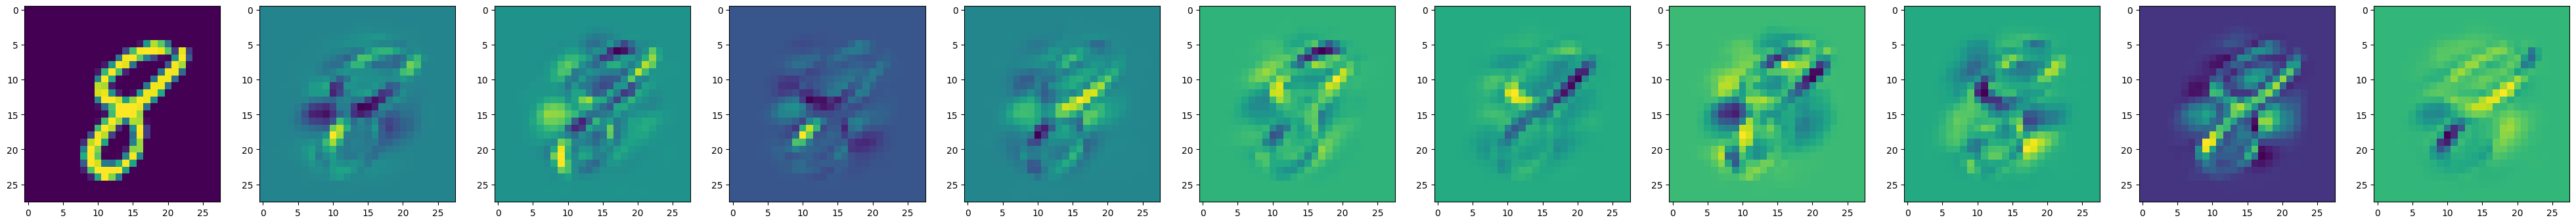

tensor(6)


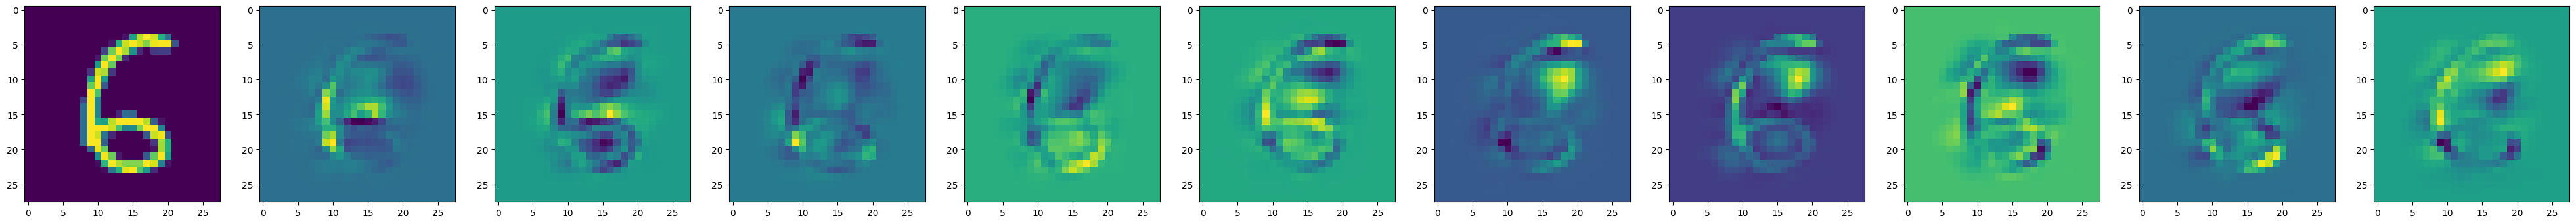

tensor(2)


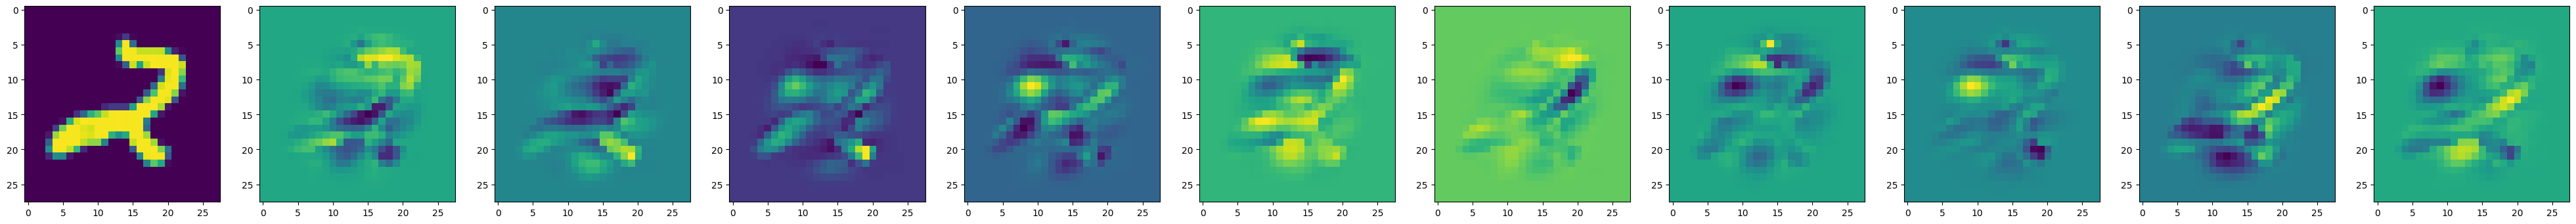

tensor(2)


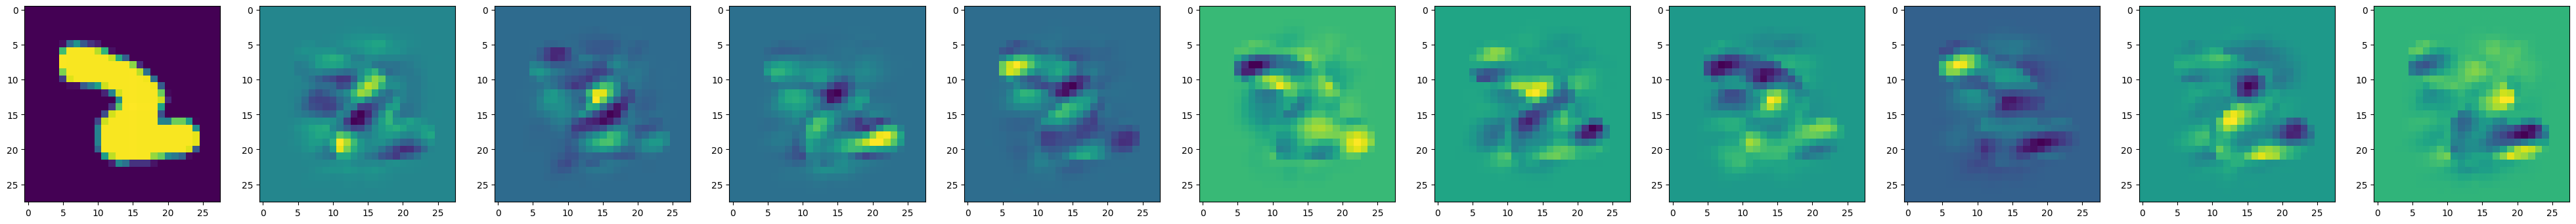

tensor(7)


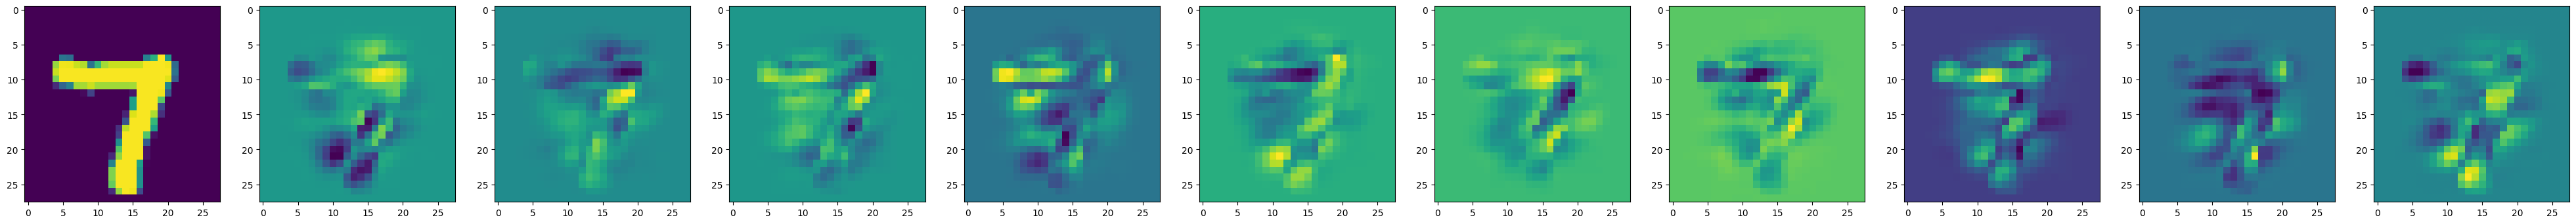

tensor(1)


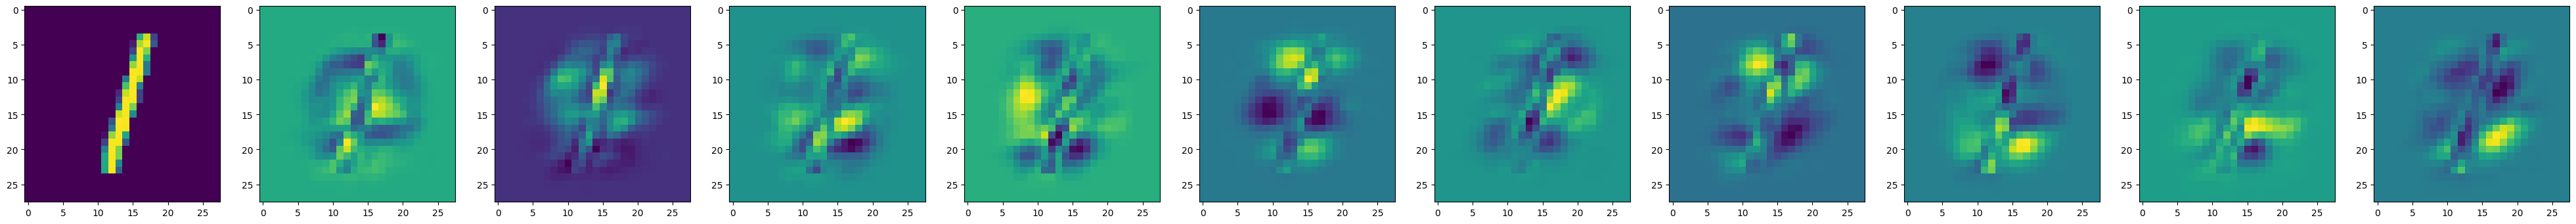

In [148]:
for a,b,c in test_loader_shap:
    a = a.reshape((-1, 28, 28))
    
    # c = c[np.arange(len(c)), b]
    # c = c.reshape((-1, 28, 28))
    # assert a.shape == c.shape
    
    for x, t, shap in zip(a, b, shaps1):
        print(t)
        fig, axs = plt.subplots(1, 11, figsize=(50, 20))
        axs[0].imshow(x)
        for i in range(10): axs[i+1].imshow(shap[i, 0])
        plt.show()

    break

In [ ]:
for x, expl_img in comb[:5]:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(shap_img)
    ax2.imshow(expl_img)
    plt.show()


## Import the Explainable model of Pan

In [4]:
model = ExplainableNet(model_d3).eval().to(device)

In [5]:
gamma = 2
model.change_lrp_rules(gamma=gamma, lrp_rule_nl=LRPRule.gamma)

In [5]:
for i, l in enumerate(model.layers):
    try: print(i, l.gamma, l.lrp_rule)
    except: print(i, str(l).split('(')[0])

0 0.0 LRPRule.z_b
1 0.0 LRPRule.alpha_beta
2 0.0 LRPRule.alpha_beta
3 MaxPool
4 0.0 LRPRule.alpha_beta
5 0.0 LRPRule.alpha_beta
6 0.0 LRPRule.alpha_beta
7 MaxPool
8 Flatten
9 0.0 LRPRule.alpha_beta


In [48]:
x = data[:1].reshape((-1,1,28,28))
expl, output, classification = get_expl(model, test_images, method)

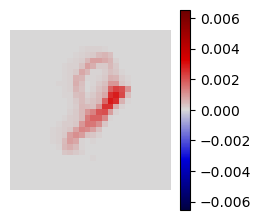

In [49]:
heatmap(expl[0].detach().reshape((28,28)), 2, 2, colorbar=True)

### Check equivalence to my implementation

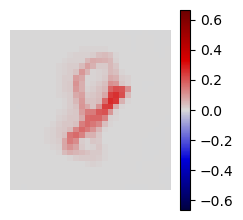

In [50]:
heatmap(rel(95)[0][0].reshape((28,28)), 2, 2, colorbar=True)

In [51]:
a = rel(95)[0][0, 0]
b = expl[0]

a.shape, b.shape

(torch.Size([28, 28]), torch.Size([28, 28]))

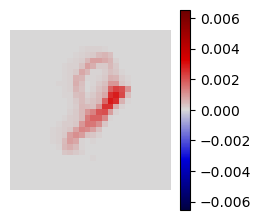

In [52]:
c = a
c[b>0] = b[b>0]
heatmap(c.detach(), colorbar=1)

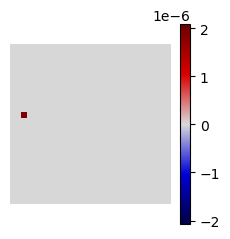

In [53]:
heatmap((a-b).detach(), colorbar=1)

In [54]:
np.abs((a-b).detach()).max()

tensor(1.9183e-06)

## SGD on Gamma

In [39]:
del ExplainableNet
from explanations_can_be_manipulated.src.nn.networks import ExplainableNet

In [5]:
model = ExplainableNet(model_d3).eval().to(device)

for i, l in enumerate(model.layers): print(i, str(l).split('(')[0])

0 Convolutional
1 Convolutional
2 Convolutional
3 MaxPool
4 Convolutional
5 Convolutional
6 Convolutional
7 MaxPool
8 Flatten
9 Dense


In [86]:
for i, l in enumerate(model.layers):
    try: print(i, l.gamma, l.lrp_rule)
    except: print(i, str(l).split('(')[0])

0 tensor([nan], requires_grad=True) LRPRule.z_b
1 tensor([nan], requires_grad=True) LRPRule.gamma
2 tensor([nan], requires_grad=True) LRPRule.gamma
3 MaxPool
4 tensor([nan], requires_grad=True) LRPRule.gamma
5 tensor([nan], requires_grad=True) LRPRule.gamma
6 tensor([nan], requires_grad=True) LRPRule.gamma
7 MaxPool
8 Flatten
9 0.0 LRPRule.alpha_beta


In [ ]:
del ExplainableNet
from explanations_can_be_manipulated.src.nn.networks import ExplainableNet

In [89]:
_, test_loader = data_loaders()

In [151]:
len(os.listdir(PICKLE_PATH + 'd3')), 1696

(1646, 1696)

In [91]:
first_batch_x, _ = first_mnist_batch()
first_batch_x.shape

torch.Size([100, 784])

In [36]:
loader_iter = iter(test_loader_shap)
batches = [next(loader_iter) for i in range(5)]

In [255]:
gamma_early = torch.Tensor([0.051]).requires_grad_(True)
gamma_late  = torch.Tensor([0.050]).requires_grad_(True)

model = ExplainableNet(model_d3).eval().to(device)
model.change_lrp_rules(gamma=gamma_early, lrp_rule_nl=LRPRule.gamma, start_l=0, end_l=3)
model.change_lrp_rules(gamma=gamma_late , lrp_rule_nl=LRPRule.gamma, start_l=4, end_l=8)

for i, l in enumerate(model.layers):
    try: print(i, l.gamma, l.lrp_rule)
    except: print(i, str(l).split('(')[0])
    
gammas, gammas_t = [], []
errs, errs_t = [], []

optimizer = torch.optim.Adam([gamma_early, gamma_late], lr=0.02)

0 tensor([0.0510], requires_grad=True) LRPRule.z_b
1 tensor([0.0510], requires_grad=True) LRPRule.gamma
2 tensor([0.0510], requires_grad=True) LRPRule.gamma
3 MaxPool
4 tensor([0.0500], requires_grad=True) LRPRule.gamma
5 tensor([0.0500], requires_grad=True) LRPRule.gamma
6 tensor([0.0500], requires_grad=True) LRPRule.gamma
7 MaxPool
8 Flatten
9 0.0 LRPRule.alpha_beta


In [258]:
loss_func = 'shap prediction_only MAE'
n_samples = 8e4    # <- the budget

n_epochs = int(.5 + n_samples / len(test_loader_shap) / batch_size)
print('n_epochs', n_epochs)

def proj(gamma):
    with torch.no_grad():
        if gamma.data < 0: gamma.zero_()
    
def log_err():
    err = shap_error(test_model, test_loader_shap)
    errs.append(err)
    errs_t.append(c_samples)
    print(f"{c_samples}/{n_samples}:", round(a, 2), round(b, 2), round(float(err), 8))

c_samples = 0
for i in tqdm(range(n_epochs)):
    for j, (x, target, shap_per_class) in (enumerate(test_loader_shap)):
        x = x.reshape((batch_size, 1, 28, 28)).data

        optimizer.zero_grad()

        # calculate entropy loss
        expl, output, classification = get_expl(model, x, method)

        # construct 'probability distribution'
        if loss_func=='entropy':
            print(expl.view(-1)[:10])
            dist = expl.abs()
            dist /= dist.sum((1,2), keepdim=True)
            ent = torch.special.entr(dist)
            print(ent)
            loss = ent.sum()
            
        elif 'shap prediction_only' in loss_func:
            shap_predicted_class = shap_per_class[np.arange(batch_size), classification][:, 0]
            shap_predicted_class = torch.Tensor(shap_predicted_class)
            
            # normalize
            if 'normalize' in loss_func:
                expl = expl / expl.abs().sum(axis=(1,2), keepdim=True)
                shap_predicted_class = shap_predicted_class / shap_predicted_class.abs().sum(axis=(1,2), keepdim=True)
            
            if 'MSE' in loss_func:
                loss = ((shap_predicted_class - expl)**2).sum()  
            elif 'MAE' in loss_func:
                loss = (shap_predicted_class - expl).abs().sum()
                
            
        # update gammas
        loss.backward()
        optimizer.step()
        # project into valid range
        proj(gamma_early)
        proj(gamma_late)
        
        a, b = float(gamma_early.detach()), float(gamma_late.detach())
        gammas.append([a, b])
        gammas_t.append(c_samples)
            
        if 0:
            clear_output()
            fig, ax = plt.subplots()
            ax.plot(gammas)
            ax.twinx().plot(losses, c='r')
            plt.plot()
            
        c_samples += batch_size
        if c_samples>n_samples: break
        
    # measure and log performance after end of ever epoch
    log_err()

  0%|          | 0/10 [00:00<?, ?it/s]

0/80000.0: 0.12 0.15 88.05563
10000/80000.0: 0.0 0.1 88.05563
20000/80000.0: 0.21 0.39 88.05563
30000/80000.0: 0.2 0.48 88.05563
40000/80000.0: 0.19 0.48 88.05563
50000/80000.0: 0.19 0.48 88.05563
60000/80000.0: 0.19 0.48 88.05563
70000/80000.0: 0.18 0.48 88.05563
80000/80000.0: 0.46 0.48 88.05563


In [ ]:
fig, ax = plt.subplots()
ax.plot(gammas)
# ax.twinx().plot(losses, c='r')

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


(83.65285186767578, 92.45841522216797)

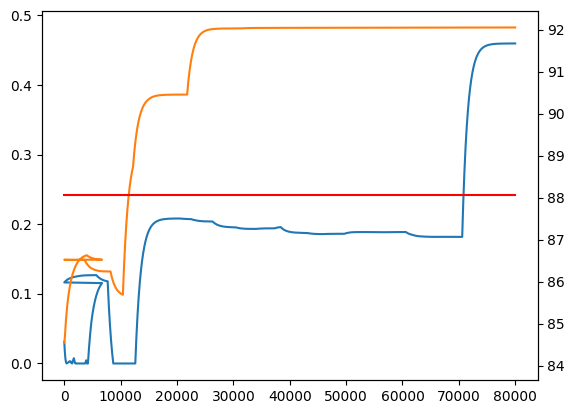

In [266]:
tag = 'results__SGD_shap__all_batches__MAE_v1'
# save_data('d3', tag, (gammas, gammas_t, errs, errs_t))

gs, gs_t, es, es_t = load_data('d3', tag)

fig, ax = plt.subplots()
ax.plot(gs_t, gs)
ax2 = ax.twinx()
ax2.plot(es_t, es, c='r')
ax2.set_ylim((min(es), max(es)))

In [267]:
(min(es), max(es))

(88.05563, 88.05563)

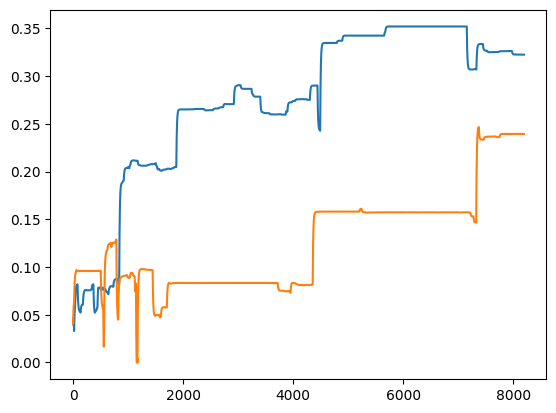

In [188]:
tag = 'results__SGD_shap__all_batches__MSE_v1'
# save_data('d3', tag, (gammas, losses))

gs, ls = load_data('d3', tag)

fig, ax = plt.subplots()
ax.plot(gs)
# ax.twinx().plot(ls, c='r')

In [245]:
len(gs)

8191

In [192]:
#### Visualizing changes in gamma

In [300]:
# first_batch
data, target, shap = next(iter(test_loader_shap))
data.shape, target.shape, shap.shape

n_img = 5

x = data[:n_img].reshape((-1, 1, 28, 28))
shap_vis = shap[np.arange(n_img), target[:n_img]].transpose(0, 2).reshape((28, 28*n_img))
x.shape, shap_vis.shape

(torch.Size([5, 1, 28, 28]), torch.Size([28, 140]))

In [295]:
def shap_error(model, test_loader_shap, distance=(lambda x, y: (x-y)**2)):
    if distance in ['corr', 'batch_corr_coef']: distance = lambda x, y: torch.corrcoef(torch.stack((x.view(-1), y.view(-1))))[0,1]
    distances = []
    with torch.no_grad():
        for x, target, shap_per_class in test_loader_shap:
            expl, output, classification = get_expl(model, x, method)
            d = distance(x, expl.reshape(x.shape))
            if len(d.shape)>0: d = d.sum() / len(d) # take average
            distances.append(d)
    return np.mean(distances)

shap_error(test_model, test_loader_shap, 'corr')

0.6690303

Step 0. Avg MSE to SHAP: 88.062286. Avg Pearson Correlation to SHAP: 0.138304.


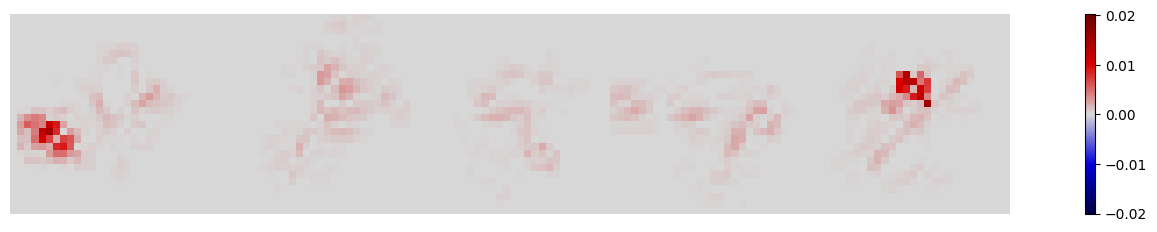

Step 96. Avg MSE to SHAP: 88.057274. Avg Pearson Correlation to SHAP: 0.521521.


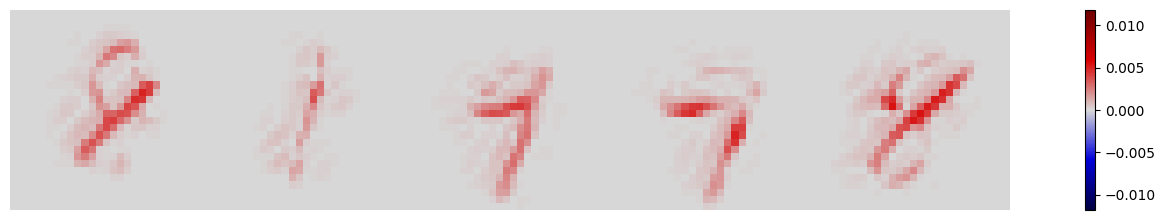

Step 193. Avg MSE to SHAP: 88.063660. Avg Pearson Correlation to SHAP: 0.072433.


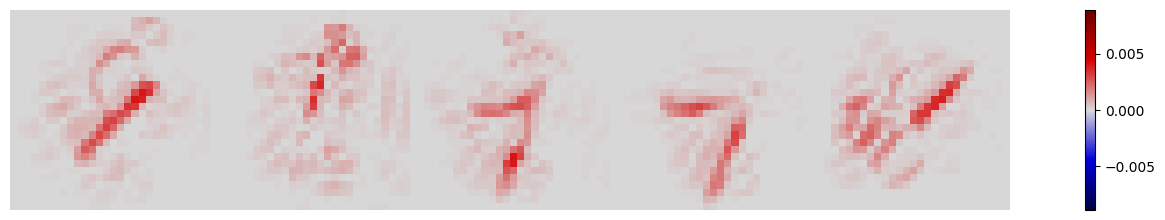

Step 289. Avg MSE to SHAP: 88.055855. Avg Pearson Correlation to SHAP: 0.638156.


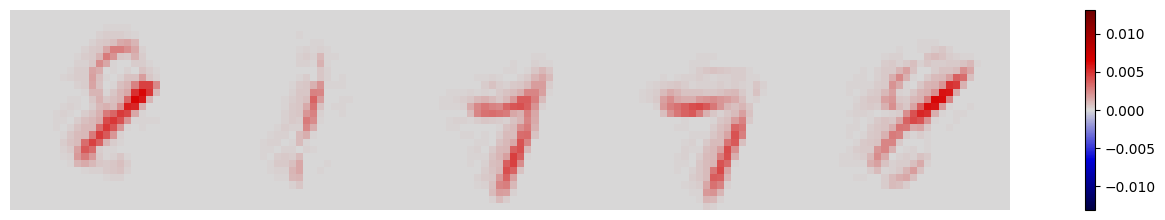

Step 386. Avg MSE to SHAP: 88.055748. Avg Pearson Correlation to SHAP: 0.639239.


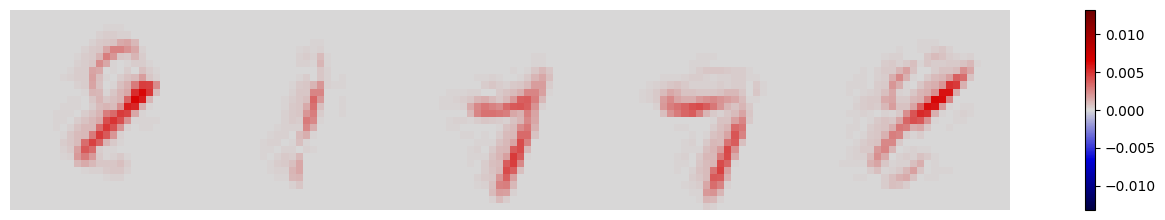

Step 482. Avg MSE to SHAP: 88.055786. Avg Pearson Correlation to SHAP: 0.629419.


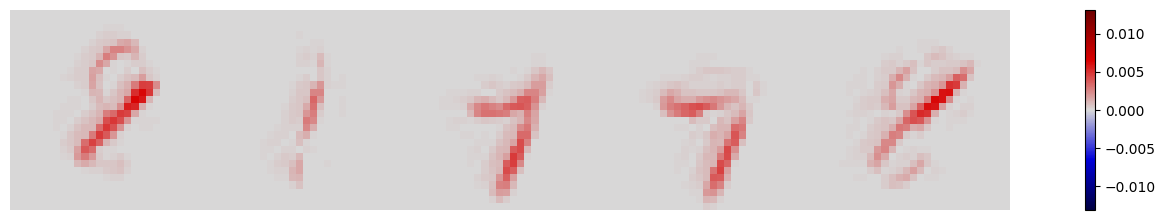

Step 579. Avg MSE to SHAP: 88.055794. Avg Pearson Correlation to SHAP: 0.626089.


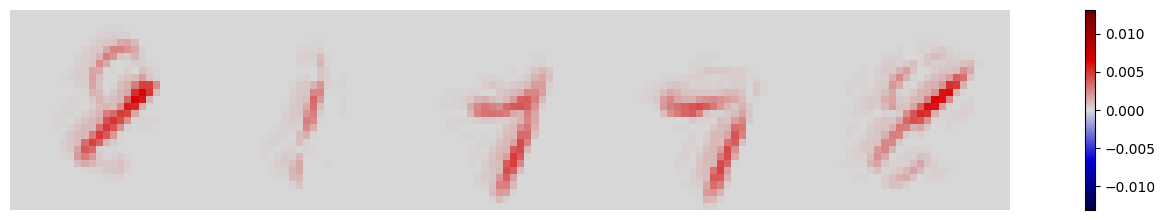

Step 675. Avg MSE to SHAP: 88.055832. Avg Pearson Correlation to SHAP: 0.611062.


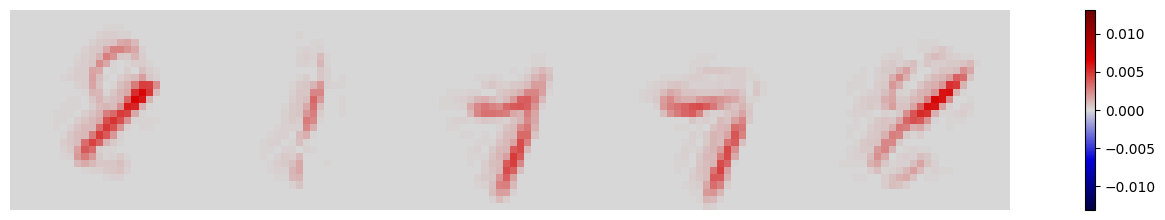

Step 772. Avg MSE to SHAP: 88.055962. Avg Pearson Correlation to SHAP: 0.606407.


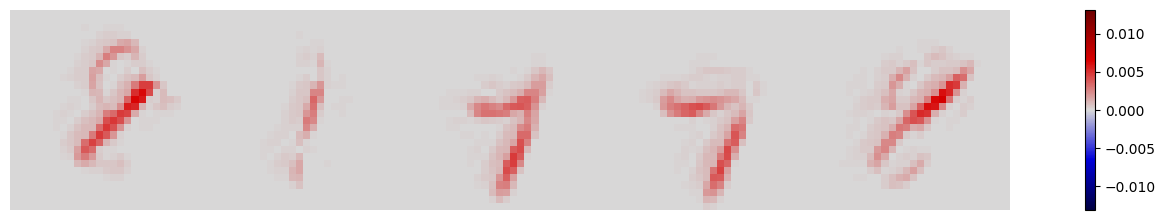

Step 868. Avg MSE to SHAP: 88.055191. Avg Pearson Correlation to SHAP: 0.669030.


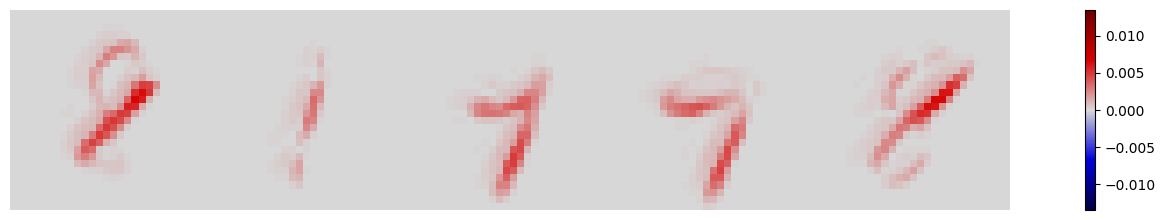

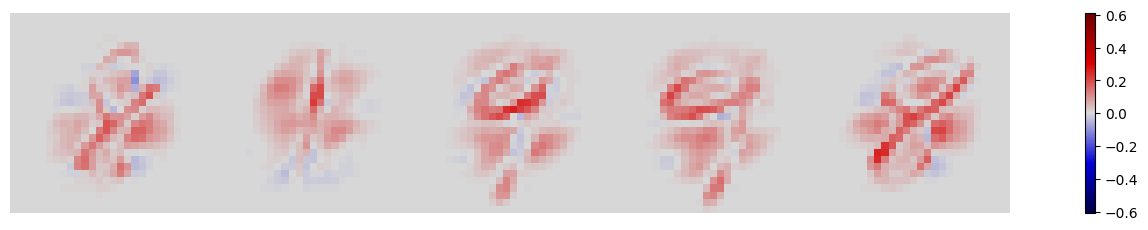

In [301]:
n = 10
l = len(gs)
idx = np.round(np.linspace(0, l - 1, n)).astype(int)

for i in idx:
    test_model = ExplainableNet(model_d3).eval().to(device)
    test_model.change_lrp_rules(gamma=gs[i][0], lrp_rule_nl=LRPRule.gamma, start_l=0, end_l=3)
    test_model.change_lrp_rules(gamma=gs[i][1] , lrp_rule_nl=LRPRule.gamma, start_l=4, end_l=8)
    expl, output, classification = get_expl(test_model, x, method)
    
    with torch.no_grad():
        mse = shap_error(test_model, test_loader_shap)
        corr = shap_error(test_model, test_loader_shap, 'corr')
        print(f"Step {gs_t[i]}. Avg MSE to SHAP: {mse:6f}. Avg Pearson Correlation to SHAP: {corr:1f}. Gammas:{gs[i].round(2)}")

        vis = expl.transpose(0,1).reshape((28, 28*n_img))
        heatmap(vis, sx=3*n_img, colorbar=True)
        plt.show()
    
heatmap(shap_vis, sx=3*n_img, colorbar=True)
plt.show()

In [303]:
n = 10
l = len(gs)
idx = np.round(np.linspace(0, l - 1, n)).astype(int)

for i in idx:
    print(f"Step {gs_t[i]}. Gammas:{gs[i]}")

Step 0. Gammas:[0.03100000135600567, 0.030000003054738045]
Step 2800. Gammas:[0.12589722871780396, 0.1487513780593872]
Step 12500. Gammas:[0.0, 0.3099888563156128]
Step 22100. Gammas:[0.2074546217918396, 0.41167697310447693]
Step 31800. Gammas:[0.1937234103679657, 0.481640487909317]
Step 41400. Gammas:[0.18788793683052063, 0.4822537899017334]
Step 51100. Gammas:[0.18855991959571838, 0.48238253593444824]
Step 60700. Gammas:[0.18831025063991547, 0.4825226366519928]
Step 70400. Gammas:[0.18186932802200317, 0.4826875925064087]
Step 80000. Gammas:[0.4597858786582947, 0.48275992274284363]


In [297]:
expl.shape

torch.Size([100, 28, 28])

In [ ]:
expl, output, classification = get_expl(test_model, x, method)

In [207]:

idx = np.round(np.linspace(0, l - 1, n)).astype(int)
idx

array([  0,  26,  51,  77, 102, 128])

In [159]:
x.shape, shap_predicted_class.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100, 28, 28]))

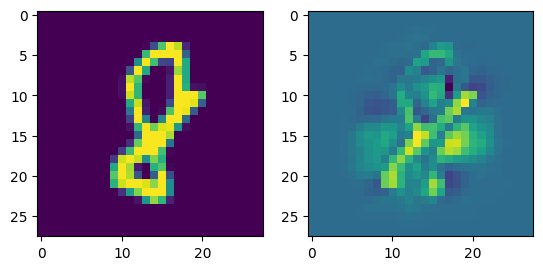

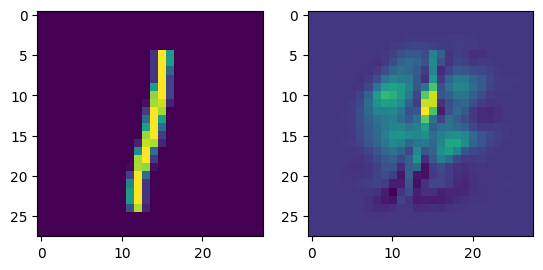

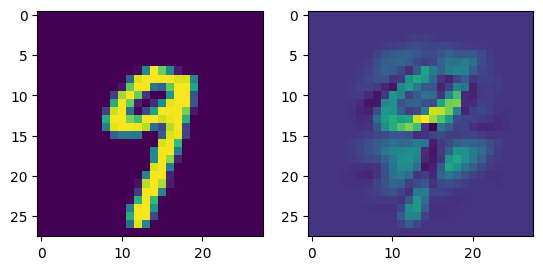

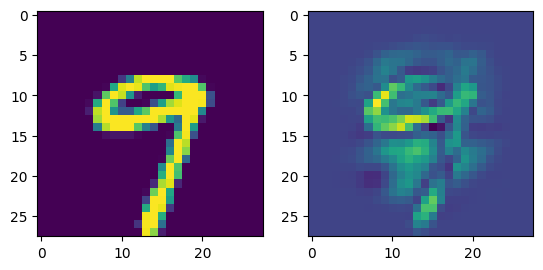

In [161]:
for img, sha in np.hstack((x.detach(), shap_predicted_class[:, None].detach()))[:4]:
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(img)
    ax2.imshow(sha)
    plt.plot()

#### minimize MSE to shapley values (first batch only)

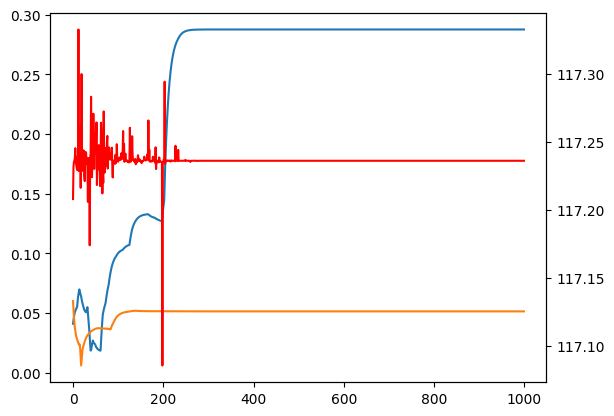

In [189]:
tag = 'results__SGD_shap__batch1__MSE_v1'
# save_data('d3', tag, (gammas, losses))

gs, ls = load_data('d3', tag)

fig, ax = plt.subplots()
ax.plot(gs)
ax.twinx().plot(ls, c='r')

In [159]:
a, b = float(gamma_early.detach().numpy()), float(gamma_late.detach().numpy())
a, b

(0.2876599133014679, 0.05137185752391815)

#### minimize expl L1 norm

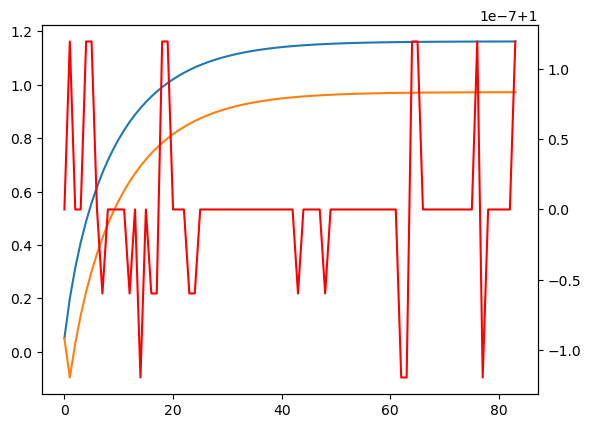

In [60]:
fig, ax = plt.subplots()
ax.plot(gammas)
ax.twinx().plot(losses, c='r')

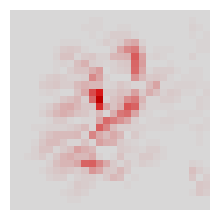

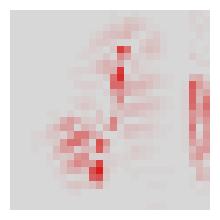

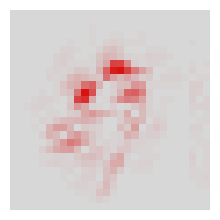

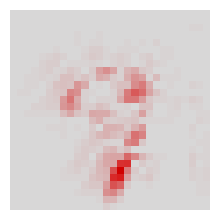

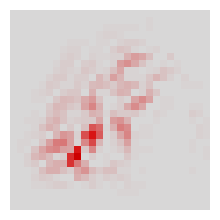

In [101]:
for ex in expl[:5]:
    heatmap(ex.detach())
    plt.show()

## Precompute Shap values

In [11]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._original_stdout
        sys.stderr = self._original_stderr

In [24]:
del tqdm
from tqdm import tqdm
_, test_loader = data_loaders(batch_size=10)

In [25]:
e = shap.DeepExplainer(model_d3, background)

In [82]:
shap_per_batch = []
# X = x
for x in tqdm(X):
    x = x.reshape((-1,1,28,28)).data
    with HiddenPrints():
        vals = e.shap_values(x)                           # dimensions: [num_classes, [datapoints, channels, x, y]]
        vals = np.stack(vals).transpose((1, 0, 2, 3, 4))  # dimensions: [datapoints, num_classes, channels, x, y]
        shap_per_batch.append(vals)

100%|█████████████████████████████████████████| 100/100 [03:05<00:00,  1.86s/it]


In [84]:
np.stack(shap_per_batch).reshape((100, 10, 1, 28, 28)).shape

(100, 10, 1, 28, 28)

In [85]:
first_batch_shap = np.stack(shap_per_batch).reshape((100, 10, 1, 28, 28))
first_batch_shap.shape

(100, 10, 1, 28, 28)

In [83]:
# first_batch_shap_old = first_batch_shap

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.detach().numpy(), 1, -1), 1, 2)

# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

## LRP computation (my implementation)

In [14]:
relevancies_per_mode = {}

In [15]:
modes = {
    0: "LRP-0.", 
    1: "Gamma. l<4 gamma=0.125",
    2: "Gamma. l<4 gamma=0.25",
    3: "Gamma. l<4 gamma=0.5",
    
    92: "Gamma. l<1000 gamma=0.25",
    95: "Gamma. l<1000 gamma=2.",
    99: "Gamma. l<1000 gamma=inf",
   
    # 99: "info."
}

In [16]:
def rel(index):
    if type(index) in [int, float]:
        index = modes[index]
    assert type(index) is str
    return copy.deepcopy(relevancies_per_mode[index])

In [17]:
A, layers = layerwise_forward_pass(model_d3, data)
L = len(layers)

A_shapes = [a.shape[1:] for a in A]

In [18]:
for mode in tqdm(modes.values()):
    if mode in relevancies_per_mode: continue
    rels = compute_relevancies(mode=mode, layers=layers, A=A, output_rels='correct class', target=target)
    if mode!="info": relevancies_per_mode[mode] = rels

  0%|          | 0/7 [00:00<?, ?it/s]

In [21]:
lrp_numpy = rel(92)[0][:3].numpy()
lrp_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in lrp_numpy[None]]

print(np.array(lrp_numpy).shape)

(1, 3, 28, 28, 1)


In [22]:
lrp_numpy[0].shape

(3, 28, 28, 1)

In [27]:
np.array(shap_numpy).shape, np.array(lrp_numpy).shape, test_numpy.shape

NameError: name 'shap_numpy' is not defined

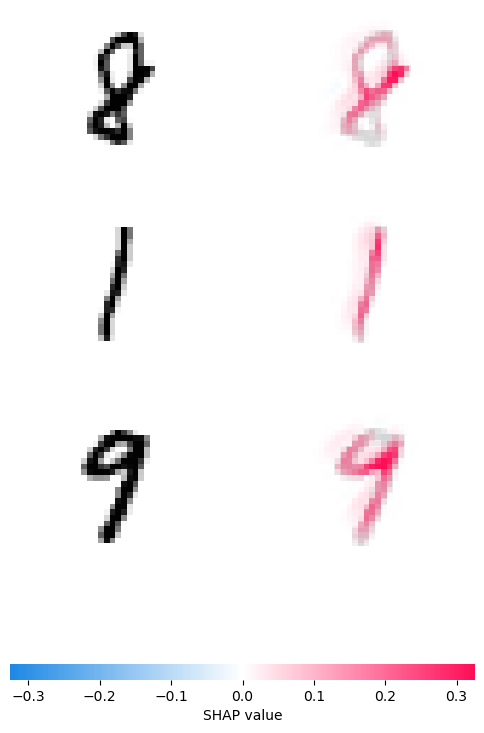

In [30]:
# plot the feature attributions
shap.image_plot(lrp_numpy, -test_numpy)